# Forward Euler solver for the heat equation

## The example

In this example, the basics of setting up a 2D transient heat equation solver using forward Euler are presented.

The PDE to be solved is:
$$
\frac{\partial T}{\partial t} = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y ^2} +q(x,y)
$$

with
$$
q(x,y) = 2(2-x^2-y^2)
$$

The domain is square on $[-1, 1]\times[-1, 1]$ and the boundary and initial conditions are:

$$T(x,y,0) = 0, \quad T(\pm 1, y, t) = 0, \quad T(0,\pm 1, t) = 0$$

The discretization assumes using $N+1$ points in each of the $x$ and $y$ directions, resulting in uniform grid spacing $h$. Using central differences for the spatial derivative, the forward Euler scheme is

$$
T_{i,j}^{n+1} = T_{i,j}^{n} + \Delta t\left[
            \frac{T_{i+1,j}^n - 2T_{i,j}^n + T_{i-1,j}^n}{h^2}
           +\frac{T_{i,j+1}^n - 2T_{i,j}^n + T_{i,j-1}^n}{h^2}
           +q(x_i, y_j)
            \right]
$$

## Code Implementation
In the code below, the solution is plotted using 2D contours.

Try changing the grid spacing and time stepping. Can you confirm the stability condition $\Delta t_{max} = \dfrac{h^2}{4\alpha}$? Note $\alpha = 1$ in this problem.

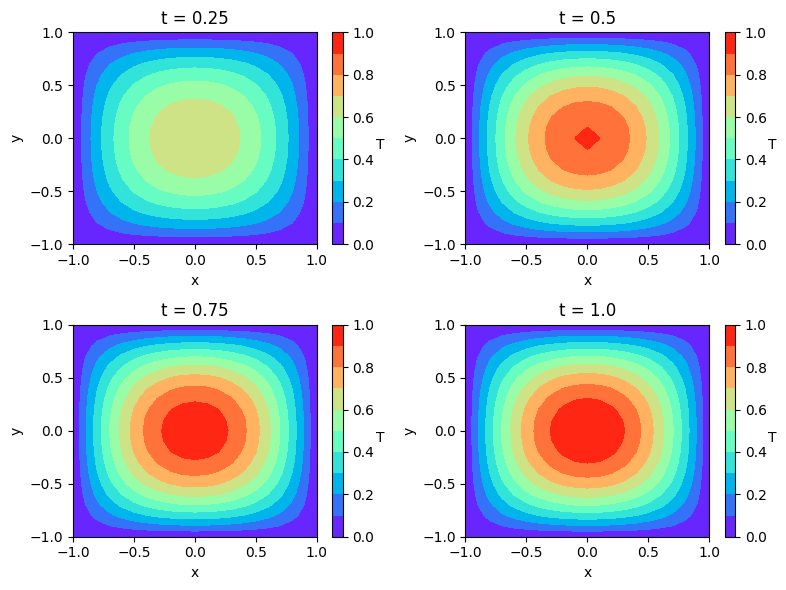

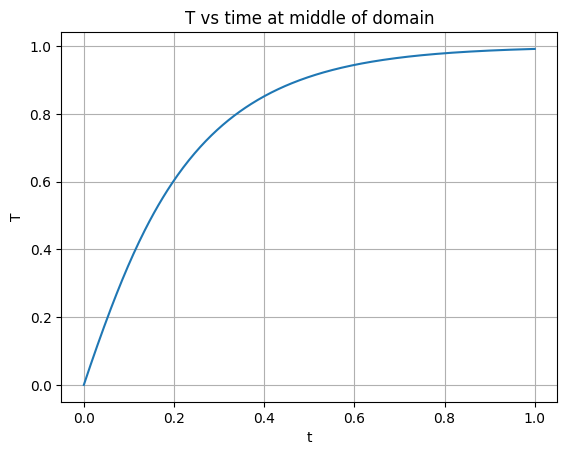

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # For animations

# Space Discretization
L = 2  # domain is -1 to 1 in each coordinate direction
N = 20 # Uniform grid spacing equal in x and y
h = L/N
x = np.linspace(-1, 1, N+1)
y = np.linspace(-1, 1, N+1)

# Time discretization
tf = 1
dt = h**2/4
Nt = int(tf/dt)
t = np.linspace(0, tf, Nt+1)

# Source term
q = lambda x,y: 2*(2 - x**2 - y**2)

# Initialize
T = np.zeros((N+1, N+1, Nt+1))

# Initial condition
T[:,:,0] = 0

'''Begin forward Euler loop'''
for n in range(Nt):

    # Loop on interior nodes
    for i in range (1,N):
        for j in range(1,N):

            # Spatial difference terms
            D2x = (T[i+1,j,n] - 2*T[i,j,n] + T[i-1,j,n])/h**2
            D2y = (T[i,j+1,n] - 2*T[i,j,n] + T[i,j-1,n])/h**2

            # Forward Euler Update
            T[i,j,n+1] = T[i,j,n] + dt*(D2x + D2y + q(x[i], y[j]))

    # Boundary nodes: note this is redundant if T is initialized to all zeros
    T[0,:,n+1] = 0 # x = -1 boundary
    T[N,:,n+1] = 0 # x = +1 boundary
    T[:,0,n+1] = 0 # y = -1 boundary
    T[:,N,n+1] = 0 # y = +1 boundary
'''End forward Euler loop'''




'''Plot contours at t = 0.25, 0.5, 0.75, 1.0'''
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
contour_regions = np.linspace(0, 1, 11) # Contours range from 0 to 1
tind = np.array([[0.25*Nt, 0.5*Nt],[0.75*Nt, Nt]], dtype=int) # Define time indices for plotting
titles = [['t = 0.25', 't = 0.5'],['t = 0.75','t = 1.0']] # Plot titleX, Y = np.meshgrid(x, y)
X, Y = np.meshgrid(x, y)
for i in range(2):
    for j in range(2):
        cont = axs[i,j].contourf(X, Y, T[:,:,tind[i][j]].T, levels=contour_regions, cmap='rainbow')
        axs[i,j].set_title(titles[i][j])
        axs[i,j].set_xlabel('x')
        axs[i,j].set_ylabel('y')
        cbar = plt.colorbar(cont, ax=axs[i][j])
        cbar.set_label('T', rotation=0)
plt.tight_layout()

'''Plot T vs t at middle of domain'''
xind = int(N/2)
yind = int(N/2)
Tplot = T[xind, yind,:]
plt.figure()
plt.plot(t, Tplot)
plt.xlabel('t')
plt.ylabel('T')
plt.title('T vs time at middle of domain')
plt.grid()

### Animated plot

The code below animates the contour plot

In [2]:
# Create meshgrid
X, Y = np.meshgrid(x, y)

# Define contour levels
contour_regions = np.linspace(0, 1, 11)

# Create initial frame (t = 0)
fig = go.Figure(
    data=[
        go.Contour(
            z=T[:, :, 0].T,
            x=x,
            y=y,
            colorscale="Rainbow",
            contours_coloring="heatmap",
            zmin=np.min(T),
            zmax=np.max(T),
            colorbar=dict(title="T"),
        )
    ]
)

# Build animation frames
frames = []
for k in range(0, len(t), max(1, len(t)//50)):  # up to ~50 frames
    frames.append(
        go.Frame(
            data=[
                go.Contour(
                    z=T[:, :, k].T,
                    x=x,
                    y=y,
                    colorscale="Rainbow",
                    contours_coloring="heatmap",
                    zmin=np.min(T),
                    zmax=np.max(T),
                )
            ],
            name=f"{t[k]:.3f}",
        )
    )

fig.frames = frames

# Slider setup
sliders = [
    {
        "pad": {"b": 10, "t": 60},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "active": 0,
        "steps": [
            {
                "args": [[f"{t[k]:.3f}"], {"frame": {"duration": 0, "redraw": True},
                                           "mode": "immediate"}],
                "label": f"{t[k]:.2f}",
                "method": "animate",
            }
            for k in range(0, len(t), max(1, len(t)//50))
        ],
    }
]

# Play/pause buttons
updatemenus = [
    {
        "type": "buttons",
        "x": 0.05,
        "y": -0.1,
        "showactive": False,
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 100, "redraw": True},
                        "fromcurrent": True,
                        "mode": "immediate",
                    },
                ],
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [
                    [None],
                    {
                        "frame": {"duration": 0, "redraw": False},
                        "mode": "immediate",
                    },
                ],
            },
        ],
    }
]

# Layout setup
fig.update_layout(
    title="Temperature Contour Evolution",
    xaxis_title="x",
    yaxis_title="y",
    width=600,
    height=600,
    updatemenus=updatemenus,
    sliders=sliders,
)

fig.show()



## 3D animated plot

In [3]:
import plotly.graph_objects as go
import numpy as np

# Create meshgrid
X, Y = np.meshgrid(x, y)

# Define min/max for consistent scaling
Tmin, Tmax = np.min(T), np.max(T)

# Create figure with initial surface
fig = go.Figure(
    data=[
        go.Surface(
            x=X,
            y=Y,
            z=T[:, :, 0].T,
            colorscale="Rainbow",
            cmin=Tmin,
            cmax=Tmax,
            colorbar=dict(title="T"),
        )
    ]
)

# Animation frames
frames = []
for k in range(0, len(t), max(1, len(t)//50)):
    frames.append(
        go.Frame(
            data=[
                go.Surface(
                    x=X,
                    y=Y,
                    z=T[:, :, k].T,
                    colorscale="Rainbow",
                    cmin=Tmin,
                    cmax=Tmax,
                )
            ],
            name=f"{t[k]:.3f}",
        )
    )
fig.frames = frames

# Slider
sliders = [
    {
        "pad": {"b": 10, "t": 60},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "active": 0,
        "steps": [
            {
                "args": [[f"{t[k]:.3f}"],
                         {"frame": {"duration": 0, "redraw": True},
                          "mode": "immediate"}],
                "label": f"{t[k]:.2f}",
                "method": "animate",
            }
            for k in range(0, len(t), max(1, len(t)//50))
        ],
    }
]

# Play/pause buttons
updatemenus = [
    {
        "type": "buttons",
        "direction": "left",
        "x": 0.1,
        "y": -0.1,
        "showactive": False,
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [
                    None,
                    {
                        "frame": {"duration": 100, "redraw": True},
                        "fromcurrent": True,
                        "mode": "immediate",
                    },
                ],
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [
                    [None],
                    {
                        "frame": {"duration": 0, "redraw": False},
                        "mode": "immediate",
                    },
                ],
            },
        ],
    }
]

# Layout with fixed z-axis
fig.update_layout(
    title="3D Temperature Evolution (Fixed z-Axis)",
    scene=dict(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="Temperature (T)",
        zaxis=dict(range=[Tmin, Tmax]),   # fix z-axis range
        aspectmode="cube"
    ),
    width=750,
    height=650,
    updatemenus=updatemenus,
    sliders=sliders,
)

fig.show()
